In [10]:
import xarray as xr
import gcsfs
from glob import glob
from tqdm import tqdm
from dask.diagnostics import ProgressBar, Profiler
import dask
import os
import shutil
import numpy as np
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import random


In [11]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize' : 12,
      'legend.fontsize' : 13,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'
plt.rcParams['figure.figsize'] = (14.,5.)

In [12]:
ddir = '/swot/SUM03/tmp/CESM/'

In [13]:
client = Client('tcp://129.236.21.48:8089')
client

Client Scheduler: tcp://129.236.21.48:8089 Dashboard: http://129.236.21.48:8787/status,Cluster Workers: 16 Cores: 16 Memory: 8.66 TB


In [14]:
ds=xr.open_zarr(ddir+'hybrid_v5_rel04_BC5_ne120_t12_pop62', auto_chunk=False).chunk({'time': 3})
ds

/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    ANGLET              (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HT                  (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTE                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTN                 (nlat, nlon) float64 dask.

In [15]:
from xbatcher import BatchGenerator

In [16]:
ds=ds.rename({'U1_1':'U', 'V1_1':'V', 'TAUX_2':'TAUX', 'TAUY_2':'TAUY', 'SSH_2':'SSH', 'ULONG':'XU', 'ULAT':'YU'})

In [27]:
def threeD_coords(lon,lat):
    X = np.sin(np.radians(lat))
    Y = np.sin(np.radians(lon))*np.cos(np.radians(lat))
    Z = -np.cos(np.radians(lon))*np.cos(np.radians(lat))
    return (X,Y,Z)

def extract_needed_variables(batch):
    shift_vars = ['SSH','XU','YU','TAUX','TAUY','SST']
    coord_vars = ['XU','YU']
    
    
    shifts = {'_e': dict(nlon_input=-1),
              '_w': dict(nlon_input=1),
             '_n': dict(nlat_input=-1),
             '_s': dict(nlat_input=1),
             '_ne': dict(nlon_input=-1,nlat_input=-1),
             '_nw': dict(nlon_input=1,nlat_input=-1),
             '_se': dict(nlon_input=-1,nlat_input=1),
             '_sw': dict(nlon_input=1,nlat_input=1),}
    
    
    for var in shift_vars:
        for suf, shift in shifts.items():
            batch[var + suf] = batch[var].shift(**shift)
            
    suffixes = ['','_e','_w','_n','_s','_ne','_nw','_se','_sw']
    for suf in suffixes:
        batch['X'+suf],batch['Y'+suf],batch['Z'+suf], = threeD_coords(batch['XU'+suf],batch['YU'+suf])
    for var in coord_vars:
        for suf in suffixes:
            batch = batch.drop([var+suf])
    
    features = ['X', 'Y', 'Z','SSH','SST','TAUX','TAUY']
    batchb = batch.drop('sample').isel(sample=slice(0,len(batch.sample),3))
    batchf = batch.drop('sample').isel(sample=slice(2,len(batch.sample),3))
    batch0 = batch.drop('sample').isel(sample=slice(1,len(batch.sample),3))     
    for vari in features:
        for suff in suffixes:
            batch0[vari+suff+'_f'] = batchf[vari+suff]
            batch0[vari+suff+'_b'] = batchb[vari+suff]
    return batch0
    
    #return batch
targets=['U','V']
features = ['X', 'Y', 'Z','SSH','SST','TAUX','TAUY']
sufx = ['','_e','_w','_n','_s','_ne','_nw','_se','_sw']

sufx2 = ['','_f','_b']
feature_cols = [feat+suf+suf2 for feat in features for suf in sufx for suf2 in sufx2]
#feature_cols = [feat+suf for feat in features for suf in sufx]


from sklearn.model_selection import train_test_split

def ds_to_df(batch, w_validation=False, choice='training'):
    #df = batch.reset_index('sample').to_dataframe()
    #X = df.dropna().reset_index(drop=True).loc[:, feature_cols]
    #y = df.dropna().reset_index(drop=True).loc[:, targets]
    #df = batch.drop('sample').to_dataframe().dropna().reset_index(drop=True)
    df = batch.to_dataframe().dropna().reset_index(drop=True)
    X = df.loc[:, feature_cols]
    y = df.loc[:, targets]
    
    if w_validation:
        X,X_t,y,y_t = train_test_split(X,y,test_size=0.2)
        if (choice=='training'):
            return (X,y)
        elif (choice=='validation'):
            return (X_t,y_t)
    else:
        return (X,y)
    

In [28]:
randdate = random.sample(range(2, 10000), 9998)


In [37]:
def actual_generator1(**kwargs):
    for rd in randdate:
        print('Day %s'%rd)
        vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
        bg = BatchGenerator(ds.isel(time = slice(rd-3,rd+1,)).reset_coords()[vars_wanted],
                        input_dims={'nlon': 600, 'nlat': 600},
                        input_overlap={'nlon' : 1, 'nlat' : 1}, batch_dims={'time': 3},
                        concat_input_dims=True)
        for batch in bg:
            yield  ds_to_df(extract_needed_variables(batch), kwargs)
            #for jt in range(len(batch.sample)):
            #    bt = batch.isel(sample=jt)
            #    yield  ds_to_df(extract_needed_variables(bt), kwargs)
        break

In [52]:
random.randint(2,10000)

6641

In [53]:
random.sample(range(2, 10000),1)[0]

8702

In [54]:
def actual_generator2(**kwargs):
    rd = random.randint(2,10000)
    print('Day %s'%rd)
    vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
    bg = BatchGenerator(ds.isel(time = slice(rd-3,rd+1,)).reset_coords()[vars_wanted],
                        input_dims={'nlon': 600, 'nlat': 600},
                        input_overlap={'nlon' : 1, 'nlat' : 1}, batch_dims={'time': 3},
                        concat_input_dims=True)
    for batch in bg:
        yield  ds_to_df(extract_needed_variables(batch), kwargs)
            #for jt in range(len(batch.sample)):
            #    bt = batch.isel(sample=jt)
            #    yield  ds_to_df(extract_needed_variables(bt), kwargs)


In [59]:
def actual_generator(**kwargs):
    vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
    bg = BatchGenerator(ds.reset_coords()[vars_wanted],
                        input_dims={'nlon': 600, 'nlat': 600},
                        input_overlap={'nlon' : 1, 'nlat' : 1}, batch_dims={'time': 3},
                        concat_input_dims=True)
    for batch in bg:
        yield  ds_to_df(extract_needed_variables(batch), kwargs)
            #for jt in range(len(batch.sample)):
            #    bt = batch.isel(sample=jt)
            #    yield  ds_to_df(extract_needed_variables(bt), kwargs)


In [60]:
import tensorflow as tf
from tensorflow import keras

In [63]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(200, activation=tf.nn.relu,
                       input_shape=(len(feature_cols),),
                       name='hidden_layer_1',),
    keras.layers.Dense(200, activation=tf.nn.relu, 
                       name='hidden_layer_2'),
    keras.layers.Dense(100, activation=tf.nn.relu, 
                       name='hidden_layer_3'),
    keras.layers.Dense(80, activation=tf.nn.relu, 
                       name='hidden_layer_4'),
    keras.layers.Dense(20, activation=tf.nn.relu, 
                       name='hidden_layer_5'),
    keras.layers.Dense(2, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
model.compile(loss='mse',
            optimizer='adam',
            metrics=['mae', 'mse','accuracy'])

# show a summary of the data
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 200)               38000     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 200)               40200     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 100)               20100     
_________________________________________________________________
hidden_layer_4 (Dense)       (None, 80)                8080      
_________________________________________________________________
hidden_layer_5 (Dense)       (None, 20)                1620      
_________________________________________________________________
output_layer (Dense)         (None, 2)                 42        
Total params: 108,042
Trainable params: 108,042
Non-trainable params: 0
_________________________________________________________________


In [64]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.mae = []
        self.val_mae = []
        self.accuracy = []
        self.val_accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.mae.append(logs.get('mean_absolute_error'))
        self.val_mae.append(logs.get('val_mean_absolute_error'))
        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(18,5))
        plt.subplot(131)
        plt.plot(self.x, self.losses,alpha=0.5,color=color2,label="loss")
        plt.plot(self.x, self.val_losses,alpha=0.5,color=color1, label="val loss")
        plt.legend()
        plt.xlabel(r'Epoch [$=1$ day if $batchsize<1$ day]');
        plt.ylabel('Mean Square Error');
        
        plt.subplot(132)
        plt.plot(self.x, self.mae,alpha=0.5,color=color2, label="training")
        plt.plot(self.x, self.val_mae,alpha=0.5,color=color1, label="validation")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel(r'Mean Abs Error [$cm/s$]');
        
        plt.subplot(133)
        plt.plot(self.x, self.accuracy,color=color2,alpha=0.5, label="training")
        plt.plot(self.x, self.val_accuracy,alpha=0.5,color=color1, label="validation")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel('Model Accuracy');
        plt.show();
        
plot_losses = PlotLosses()

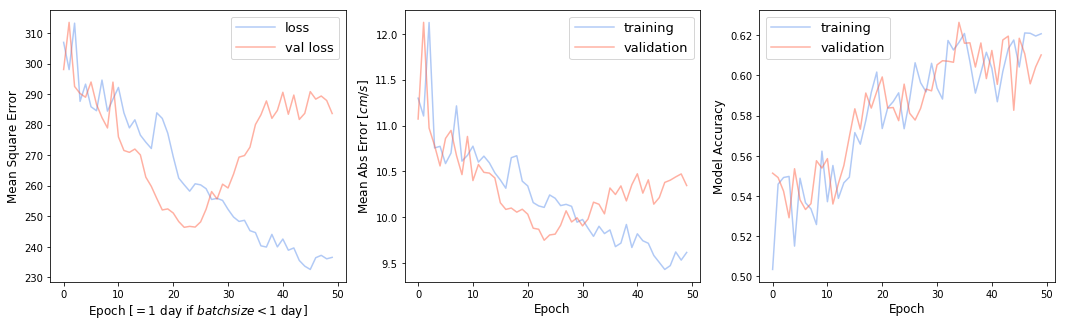

1/1 [==============================] - 449s 449s/step - loss: 236.5436 - mean_absolute_error: 9.6169 - mean_squared_error: 236.5122 - acc: 0.6207 - val_loss: 283.6513 - val_mean_absolute_error: 10.3463 - val_mean_squared_error: 283.5965 - val_acc: 0.6102
Epoch 51/750


In [ ]:
model_hist = model.fit_generator(generator=actual_generator(w_validation=True, choice='training'),
                                 validation_data=actual_generator(w_validation=True, choice='validation'),
                                 steps_per_epoch=1, validation_steps=1, epochs=750, callbacks=[plot_losses])
#, use_multiprocessing=True, workers=10)


In [ ]:
ds_test = ds.isel(time=slice(0,4))

In [36]:
%%time
for rd in randdate:
    vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
    bg = BatchGenerator(ds.isel(time = slice(rd-3,rd+1,)).reset_coords()[vars_wanted],
                    input_dims={'nlon': 600, 'nlat': 600},
                    input_overlap={'nlon' : 1, 'nlat' : 1}, batch_dims={'time': 3},
                    concat_input_dims=True)
    for batch in bg:
        #batchx = (extract_needed_variables(batch))
        X_tr, y_tr = ds_to_df(extract_needed_variables(batch))
        break
    break

CPU times: user 1min 20s, sys: 1min 6s, total: 2min 26s
Wall time: 2min 27s


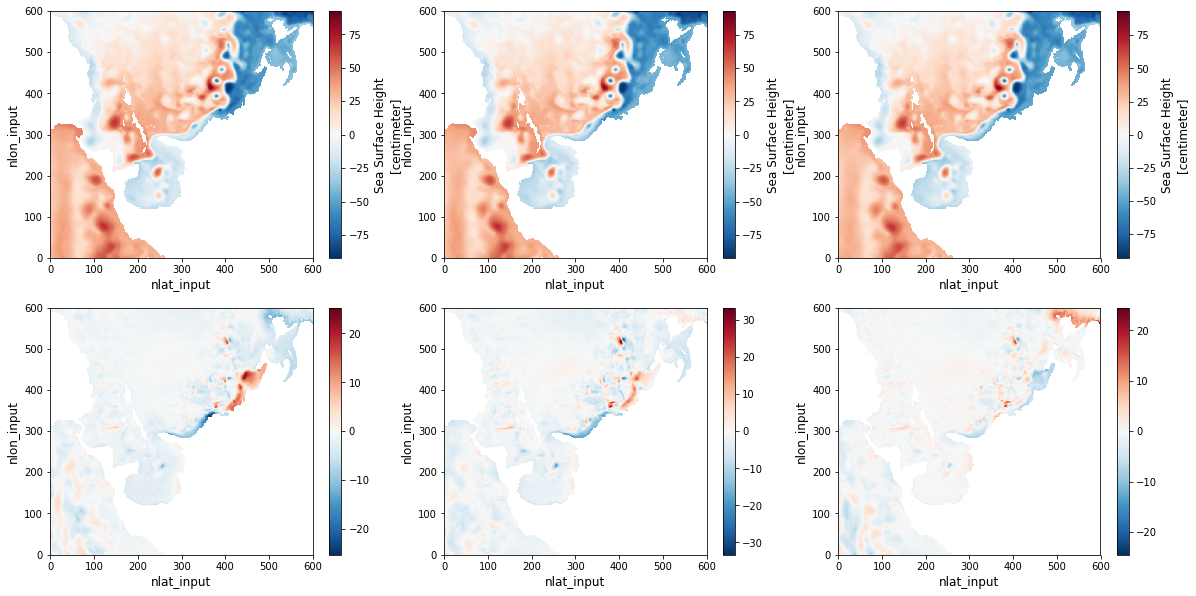

In [196]:
plt.figure(figsize=(20,10))
plt.subplot(231)
batchx.SSH_e_b.isel(sample=2).plot()
plt.subplot(232)
batchx.SSH_e.isel(sample=2).plot()
plt.subplot(233)
batchx.SSH_e_f.isel(sample=2).plot()
plt.subplot(234)
(batchx.SSH_e - batchx.SSH_e_b).isel(sample=2).plot()
plt.subplot(235)
(batchx.SSH_e_f - batchx.SSH_e_b).isel(sample=2).plot()
plt.subplot(236)
(batchx.SSH_e_f - batchx.SSH_e).isel(sample=2).plot()
